<a href="https://colab.research.google.com/github/SolemnShark871/Churn/blob/main/NN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [5]:
## General packages
import pandas as pd
import numpy as np
import os
import math
from google.colab import drive
from pandas_profiling import ProfileReport
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from keras.layers import Dense, Dropout

import scipy
import scipy.stats as stats
from sklearn.decomposition import PCA

## Neural networks packages
from keras import layers, models
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

## Neural networks packages
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from keras import layers, models
from keras.layers import Dense, Dropout
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.constraints import maxnorm
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold

In [6]:
drive.mount('/content/drive', force_remount= True)
os.chdir('/content/drive/MyDrive/Churn') #Thomas & Favio & Juan

os.listdir("./")

Mounted at /content/drive


['personas_retiradas.csv',
 'non_retired_people.csv',
 'retired_people.csv',
 'Datasets_Churn.ipynb',
 'ML models.ipynb',
 'Images',
 'Copy of Spotify challenge.ipynb',
 'not_scaled_not_pca_merged.csv',
 'pca_merged_scaled.csv',
 'not_scaled_not_lambda_merged.csv',
 'standarised_not_pca_merged.csv',
 'pca_merged_standarised.csv',
 'Data_exploration.ipynb',
 'SVM_Model.ipynb',
 'LogReg.ipynb',
 'NN model.ipynb']

In [7]:
df_lamda = pd.read_csv('pca_merged_standarised.csv', index_col = [0])

df_lamda2 = pd.read_csv('standarised_not_pca_merged.csv', index_col = [0])

#df_lamda.head()

# Neural network

## PCA

In [8]:
### Train test split FOR NUMERICAL ALGORITHMS: 20% test
X = df_lamda.drop(['LABEL'], axis = 1)
y = df_lamda['LABEL']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, stratify = y)
X_train, X_val, y_train, y_val = train_test_split( X_train, y_train, test_size=0.2, random_state=1234, stratify = y_train)

In [9]:
# Tuneo
# Optimizer, loss, layers number, neurons per each layer, batch size, epochs, 
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [10]:
# Function to create model, required for KerasClassifier
def create_model(
    # Default values
    activation: 'relu',
    dropout_rate : 0,
    init_mode: 'uniform',
    #weight_constraint: 1,
    optimizer: 'adam',
    #learn_rate: 0.01,
    hiden_layers: 2,
    units: [2, 2]) -> tf.keras.Sequential:
    
    # Create the model
    model = Sequential()
    model.add(Dense(X.shape[1], kernel_initializer =  init_mode, activation = activation))
    
    for i in range(hiden_layers):
        model.add(Dense(units = units[i], activation = activation))
        
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, kernel_initializer = init_mode, activation = 'sigmoid'))
    model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ['accuracy'])
    
    return model

In [11]:
model = KerasClassifier(build_fn=create_model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  """Entry point for launching an IPython kernel.


In [12]:
param_grid = {
    "activation": ['selu','softsign','softplus','softmax'],
    #"learn_rate": [0.1, 0.2],
    "init_mode": ['he_normal', 'glorot_normal'],
    #"weight_constraint": [1, 2, 3, 4, 5],
    "dropout_rate": [0.8],
    "units": [[8, 4]],
    "optimizer": ['RMSprop', 'Adam', 'SGD'],
    "hiden_layers": [2],
    "epochs": [15],
    "batch_size":  [128]
}

In [13]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring="accuracy", n_jobs=-1, verbose = 2)

In [14]:
grid_search.fit(X_train.values, y_train.values)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


KeyboardInterrupt: ignored

In [ ]:
grid_search.best_params_

In [15]:
model_f = create_model(activation = "softsign", dropout_rate = 0.8, optimizer = 'Adam', init_mode = 'glorot_normal',
                       hiden_layers = 2, units = [8, 4])

Score for fold 1: loss of 0.5137683153152466; accuracy of 81.42292499542236%
Score for fold 2: loss of 0.3743050694465637; accuracy of 84.58498120307922%
Score for fold 3: loss of 0.32257840037345886; accuracy of 87.74703741073608%
Score for fold 4: loss of 0.3550460934638977; accuracy of 83.79446864128113%
Score for fold 5: loss of 0.31518107652664185; accuracy of 86.95651888847351%
Average scores for all folds:
> Accuracy: 84.90118622779846 (+- 2.2692012663525456)
> Loss: 0.37617579102516174


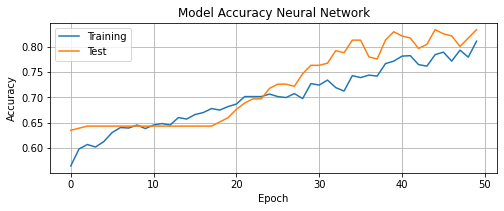

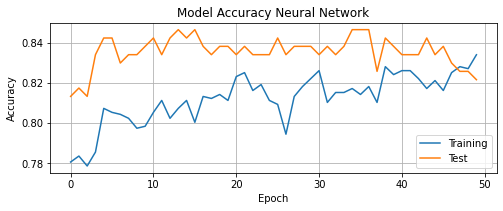

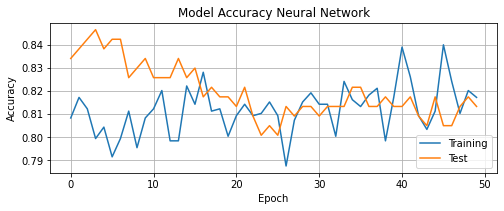

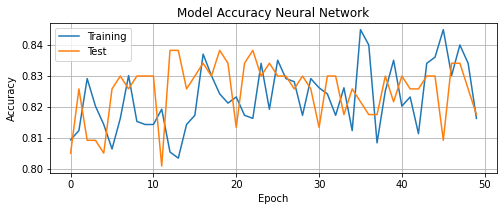

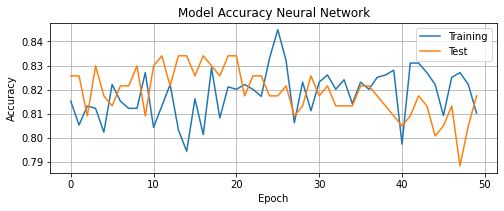

In [16]:
# Define the K-fold Cross Validator
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)

# Define per-fold score containers <-- these are new
acc_per_fold = []
loss_per_fold = []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):

  history = model_f.fit(inputs[train], targets[train], batch_size = 264, epochs = 50,
                      validation_data = (X_val.values, y_val.values), verbose = 0)

  # Generate generalization metrics
  scores = model_f.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model_f.metrics_names[0]} of {scores[0]}; {model_f.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Plot the accuracy for test and train data
  fig = plt.figure(figsize = (8, 16))
  ax = fig.add_subplot(num_folds, 1, 1)

  ax.plot(history.history['accuracy'])
  ax.plot(history.history['val_accuracy'])

  ax.set_title('Model Accuracy Neural Network')
  ax.set_xlabel('Epoch')

  ax.set_ylabel('Accuracy')
  ax.legend(['Training', 'Test'], loc = 'best')
  ax.grid()

  # Increase fold number
  fold_no = fold_no + 1

# == Provide average scores ==
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

In [17]:
history = model_f.fit(X_train.values, y_train.values, batch_size = 264, epochs = 50,
                      validation_data = (X_val.values, y_val.values), verbose = 0)

In [18]:
loss, accuracy = model_f.evaluate(X_test.values, y_test.values, verbose = 1)

10/10 [==============================] - 0s 2ms/step - loss: 0.3252 - accuracy: 0.8709


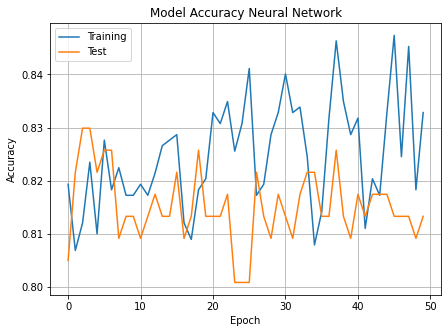

In [19]:
# Plot the accuracy for test and train data
fig = plt.figure(figsize = (7, 5))
ax = fig.add_subplot(1, 1, 1)

ax.plot(history.history['accuracy'])
ax.plot(history.history['val_accuracy'])

ax.set_title('Model Accuracy Neural Network')
ax.set_xlabel('Epoch')
#plt.xticks(np.arange(0, 1.1, step = 0.1), rotation = 'vertical')
ax.set_ylabel('Accuracy')
ax.legend(['Training', 'Test'], loc = 'best')
ax.grid()
#ax.figure.savefig(RESULTS_PATH + 'accuracy_normalized.png')
#ax.figure.savefig(RESULTS_PATH + 'accuracy_standarized.png')

## Non PCA

In [26]:
### Train test split FOR NUMERICAL ALGORITHMS: 20% test
X1 = df_lamda2.drop(['LABEL'], axis = 1)
y1 = df_lamda2['LABEL']

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=1234, stratify = y1)
X_train1, X_val1, y_train1, y_val1 = train_test_split( X_train1, y_train1, test_size=0.2, random_state=1234, stratify = y_train1)

In [27]:
model_f = create_model(activation = "softsign", dropout_rate = 0.8, optimizer = 'Adam', init_mode = 'glorot_normal',
                       hiden_layers = 2, units = [8, 4])

Score for fold 1: loss of 0.4090435206890106; accuracy of 84.98023748397827%
Score for fold 2: loss of 0.26748305559158325; accuracy of 91.69960618019104%
Score for fold 3: loss of 0.19659221172332764; accuracy of 94.46640610694885%
Score for fold 4: loss of 0.15244384109973907; accuracy of 95.25691866874695%
Score for fold 5: loss of 0.14373835921287537; accuracy of 95.25691866874695%
Average scores for all folds:
> Accuracy: 92.33201742172241 (+- 3.901648930920016)
> Loss: 0.23386019766330718


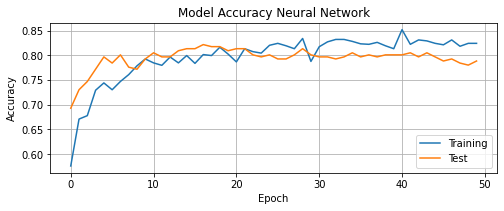

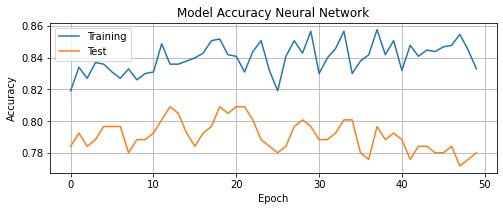

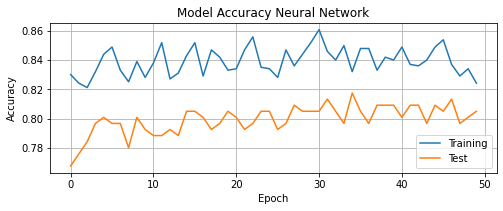

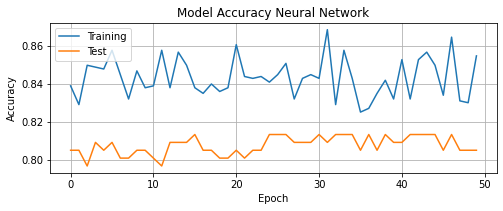

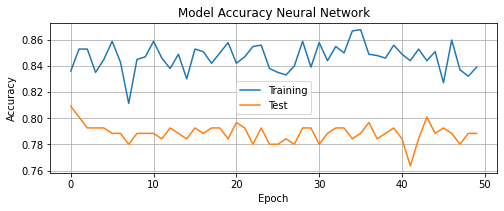

In [28]:
# Define the K-fold Cross Validator
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)
inputs = np.concatenate((X_train1, X_test1), axis=0)
targets = np.concatenate((y_train1, y_test1), axis=0)

# Define per-fold score containers <-- these are new
acc_per_fold = []
loss_per_fold = []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):

  history = model_f.fit(inputs[train], targets[train], batch_size = 264, epochs = 50,
                      validation_data = (X_val1.values, y_val1.values), verbose = 0)

  # Generate generalization metrics
  scores = model_f.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model_f.metrics_names[0]} of {scores[0]}; {model_f.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Plot the accuracy for test and train data
  fig = plt.figure(figsize = (8, 16))
  ax = fig.add_subplot(num_folds, 1, 1)

  ax.plot(history.history['accuracy'])
  ax.plot(history.history['val_accuracy'])

  ax.set_title('Model Accuracy Neural Network')
  ax.set_xlabel('Epoch')

  ax.set_ylabel('Accuracy')
  ax.legend(['Training', 'Test'], loc = 'best')
  ax.grid()

  # Increase fold number
  fold_no = fold_no + 1

# == Provide average scores ==
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

In [30]:
history = model_f.fit(X_train1.values, y_train1.values, batch_size = 264, epochs = 50,
                      validation_data = (X_val1.values, y_val1.values), verbose = 0)

In [31]:
loss, accuracy = model_f.evaluate(X_test1.values, y_test1.values, verbose = 1)

10/10 [==============================] - 0s 2ms/step - loss: 0.1091 - accuracy: 0.9669


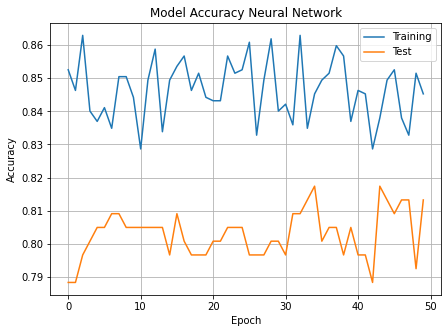

In [32]:
# Plot the accuracy for test and train data
fig = plt.figure(figsize = (7, 5))
ax = fig.add_subplot(1, 1, 1)

ax.plot(history.history['accuracy'])
ax.plot(history.history['val_accuracy'])

ax.set_title('Model Accuracy Neural Network')
ax.set_xlabel('Epoch')
#plt.xticks(np.arange(0, 1.1, step = 0.1), rotation = 'vertical')
ax.set_ylabel('Accuracy')
ax.legend(['Training', 'Test'], loc = 'best')
ax.grid()
#ax.figure.savefig(RESULTS_PATH + 'accuracy_normalized.png')
#ax.figure.savefig(RESULTS_PATH + 'accuracy_standarized.png')